In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [4]:
LAG = 48
EPS = 120
SIND = 30
# SIND = 35
HSIZE = 256
STOPS = 5
DIFF = 1
DEEP = False
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
dset = SingleStop(
    SROUTE, SIND, 'train', 32, 
    lag=LAG, stops=STOPS, diff=DIFF).generator()
evalset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=LAG, stops=STOPS, diff=DIFF).generator(shuffle=False)

Locals dataset: train (metadata/8h/M102_0.json)
 [*] Loaded routes: 1 (0.01s)
 [*] Has trainable inds: 9821
 [*] Subset train: 527
 [*] Subset in Stop-30: 218
Locals dataset: test (metadata/8h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 9821
 [*] Subset test: 117
 [*] Subset in Stop-30: 58


In [6]:
from models.temporal.RNN import *

In [7]:
if not DEEP:
    model = RNN_MIN(hidden_size=HSIZE, steps=STOPS).to(device)
else:
    model = RNN(hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device

In [8]:
criterion, opt, sch = model.params(lr=0.005)

In [9]:
# SOI (stop of interest) is the 0th stop
mseop = lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0])
evaluate(evalset, model, crit=lambda _y, y: mseop(_y, y).item())

Eval loss: 5.2595 


In [10]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(evalset, model, crit=lambda _y, y: mseop(_y, y).item(), result=True))
    sys.stdout.flush()
    sch.step()

[1/120 : 6/6] - L3.86      
Eval loss: 4.9746 
[2/120 : 6/6] - L3.47      
Eval loss: 4.7190 
[3/120 : 6/6] - L3.63      
Eval loss: 4.4897 
[4/120 : 6/6] - L3.60      
Eval loss: 4.2839 
[5/120 : 6/6] - L3.66      
Eval loss: 4.0992 
[6/120 : 6/6] - L3.15      
Eval loss: 3.9334 
[7/120 : 6/6] - L3.44      
Eval loss: 3.7846 
[8/120 : 6/6] - L3.24      
Eval loss: 3.6510 
[9/120 : 6/6] - L3.19      
Eval loss: 3.5309 
[10/120 : 6/6] - L3.24      
Eval loss: 3.4232 
[11/120 : 6/6] - L3.28      
Eval loss: 3.3263 
[12/120 : 6/6] - L3.88      
Eval loss: 3.2394 
[13/120 : 6/6] - L3.05      
Eval loss: 3.1612 
[14/120 : 6/6] - L3.23      
Eval loss: 3.0910 
[15/120 : 6/6] - L3.37      
Eval loss: 3.0279 
[16/120 : 6/6] - L3.19      
Eval loss: 2.9712 
[17/120 : 6/6] - L2.93      
Eval loss: 2.9202 
[18/120 : 6/6] - L3.27      
Eval loss: 2.8744 
[19/120 : 6/6] - L2.86      
Eval loss: 2.8333 
[20/120 : 6/6] - L2.87      
Eval loss: 2.7963 
[21/120 : 6/6] - L2.98      
Eval loss: 2.7630 
[

In [11]:
VIEW_LAG=96
viewset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=VIEW_LAG, stops=5, diff=DIFF)
viewset = [viewset[ii] for ii in range(1)]

Locals dataset: test (metadata/16h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 262
 [*] Subset test: 15
 [*] Subset in Stop-30: 1


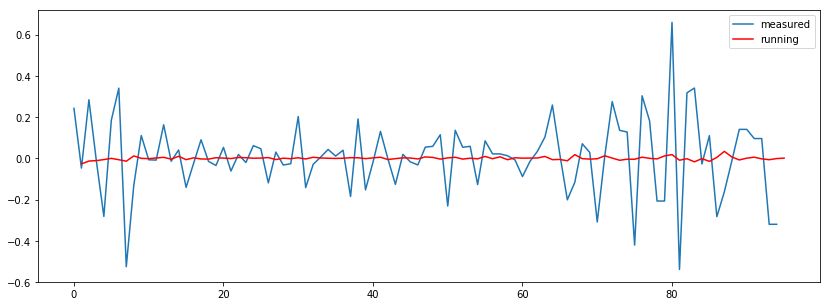

In [12]:
# STOPS = 5
show_eval_rnn(viewset, model)
# torch.save(model.state_dict(), 'checkpoints/rnn_thin_n1.pth')

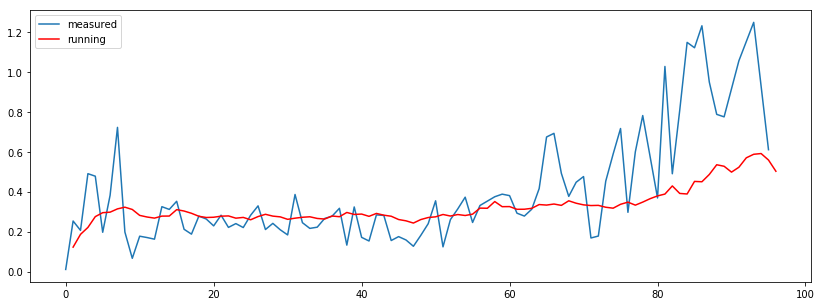

In [11]:
# STOPS = 5
show_eval_rnn(viewset, model)
# torch.save(model.state_dict(), 'checkpoints/rnn_thin_n1.pth')